In [34]:
knitr::opts_chunk$set(echo = TRUE)
options(htmltools.dir.version = FALSE)
library(pacman)
p_load(FSM,car,lfe, skedastic, parallel,GGally,broom,kableExtra, estimatr,plm,leaflet, gganimate, ggplot2, ggthemes, viridis, dplyr, magrittr, knitr,pagedown,tibble,latex2exp,MASS,stargazer,tidyr,psych,reshape2)

# Feeding Minds: How Lunch Status and Parental Education Affect Student Performance
**Food for Thought Research** - Chelsea Javier, Chelsea Jimenez, Nayeli De Anda

## Summary: 
This project investigates how lunch status such as free/reduced vs. standard correlates with student exam performance, exploring whether this relationship is influenced by parental education levels. By examining these socioeconomic factors, the study aims to examine potential disparities in academic outcomes and provide insights into how resources like school lunch programs may affect educational equity.  

## Research Question: How does lunch status (free/reduced vs. standard) correlate with student performance in exams, and does this relationship vary by parental education level?

### Null Hypothesis (H0):
There is no significant interaction between lunch status (free/reduced vs. standard) and parental education level on student exam performance. Any observed differences in exam scores among students with varying lunch statuses and parental education levels are due to random variation.

### Alternative Hypothesis (H1): 
There is a significant interaction between lunch status and parental education level on student exam performance. Specifically, the effect of lunch status on exam scores varies depending on parental education level, with students from families with lower parental education levels and free/reduced lunch status performing differently than other groups.

In [35]:
install.packages('readr')
library(readr)

Installing package into ‘/srv/r’
(as ‘lib’ is unspecified)



In [36]:
students <- read_csv('StudentsPerformance.csv')
print(students)

Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, race/ethnicity, parental level of education, lunch, test pr...
dbl (3): math score, reading score, writing score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 1,000 × 8
   gender `race/ethnicity` parental level of educ…¹ lunch test preparation cou…²
   <chr>  <chr>            <chr>                    <chr> <chr>                 
 1 female group B          bachelor's degree        stan… none                  
 2 female group C          some college             stan… completed             
 3 female group B          master's degree          stan… none                  
 4 male   group A          associate's degree       free… none                  
 5 male   group C          some college             stan… none                  
 6 female group B          associate's degree       stan… none                  
 7 female group B          some college             stan… completed             
 8 male   group B          some college             free… none                  
 9 male   group D          high school              free… completed             
10 female group B          high school              free… none                  
# ℹ 99

In [55]:
unique(students$parental_level_of_education)

[1] "bachelor's degree"  "some college"       "master's degree"   
[4] "associate's degree" "high school"        "some high school"

In [37]:
str(students)

spc_tbl_ [1,000 × 8] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ gender                     : chr [1:1000] "female" "female" "female" "male" ...
 $ race/ethnicity             : chr [1:1000] "group B" "group C" "group B" "group A" ...
 $ parental level of education: chr [1:1000] "bachelor's degree" "some college" "master's degree" "associate's degree" ...
 $ lunch                      : chr [1:1000] "standard" "standard" "standard" "free/reduced" ...
 $ test preparation course    : chr [1:1000] "none" "completed" "none" "none" ...
 $ math score                 : num [1:1000] 72 69 90 47 76 71 88 40 64 38 ...
 $ reading score              : num [1:1000] 72 90 95 57 78 83 95 43 64 60 ...
 $ writing score              : num [1:1000] 74 88 93 44 75 78 92 39 67 50 ...
 - attr(*, "spec")=
  .. cols(
  ..   gender = col_character(),
  ..   `race/ethnicity` = col_character(),
  ..   `parental level of education` = col_character(),
  ..   lunch = col_character(),
  ..   `test preparation course` 

In [38]:
names(students) <- tolower(gsub(' ', '_', names(students)))

In [39]:
names(students)

[1] "gender"                      "race/ethnicity"             
[3] "parental_level_of_education" "lunch"                      
[5] "test_preparation_course"     "math_score"                 
[7] "reading_score"               "writing_score"

In [40]:
library(psych)
describe(students)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gender*,1,1000,1.482,0.4999259,1,1.47750,0.0000,1,2,1,0.07193866,-1.99681865,0.01580905
race/ethnicity*,2,1000,3.174,1.1571789,3,3.20375,1.4826,1,5,4,-0.14427546,-0.75377937,0.03659321
parental_level_of_education*,3,1000,3.486,1.8295221,3,3.48250,2.9652,1,6,5,-0.03005665,-1.44625488,0.05785457
lunch*,4,1000,1.645,0.4787528,2,1.68125,0.0000,1,2,1,-0.60513489,-1.63544421,0.01513949
test_preparation_course*,5,1000,1.642,0.4796520,2,1.67750,0.0000,1,2,1,-0.59150381,-1.65177202,0.01516793
math_score,6,1000,66.089,15.1630801,66,66.37750,14.8260,0,100,100,-0.27809890,0.26106523,0.47949869
reading_score,7,1000,69.169,14.6001919,70,69.50125,14.8260,17,100,83,-0.25832772,-0.07976785,0.46169861
writing_score,8,1000,68.054,15.1956570,69,68.40750,16.3086,10,100,90,-0.28857622,-0.04511069,0.48052887


In [41]:
mean_scores <- students %>%
  group_by(lunch, parental_level_of_education) %>%
  summarise(across(c(math_score, reading_score, writing_score), 
                   ~ mean(.x, na.rm = TRUE)), 
            .groups = 'drop') %>%
  pivot_longer(cols = c(math_score, reading_score, writing_score), 
               names_to = 'subject', 
               values_to = 'mean_score')

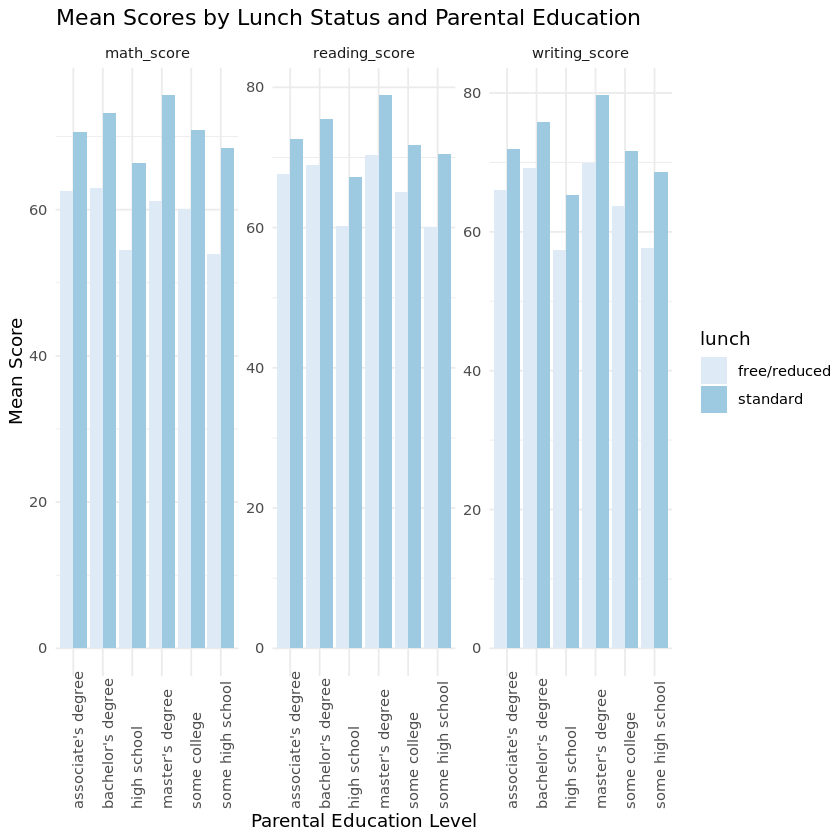

In [42]:
ggplot(mean_scores, aes(x = parental_level_of_education, y = mean_score, fill = lunch)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  facet_wrap(~subject, scales = 'free_y') +
  theme_minimal() +
  labs(title = 'Mean Scores by Lunch Status and Parental Education', 
       x = 'Parental Education Level', y = 'Mean Score') +
  scale_fill_brewer(palette = 'Blues') +
  theme(axis.text.x = element_text(angle = 90, hjust = 0))

### Results: 
The plot above shows us the mean scores of math, reading, and writing by parental education level and student lunch status (free/reduced vs. standard). The plot indicates that standard lunch students perform better than students with free/reduced lunch, across all subjects. Students with standard lunch consistently achieve higher mean scores compare to those with free/reduced lunch. This indicates a potential link between lunch status (a proxy for socioeconomic status) and academic performance.

Students with parents who have higher education levels (bachelor's/master's degrees) tend to perform better across all subjects (ie. students whose parents have master's degrees have noticeably higher scores than those whose parents have some high school education. 

For all three subjects, there are similar trends that show the effects of lunch status and parental education are consistent. The performance gap between lunch status narrows slightly as parental education increases, but the gap persists at all education levels. This suggests that parental education level and lunch status (socioeconomic factors) may both contribute independently to academic performance.

In [43]:
# combining math_score, reading_score, and writing_score into one variable = test_scores using the mean score
students$testscores <- rowMeans(students[, c('math_score', 'reading_score', 'writing_score')], na.rm = TRUE)
head(students)

gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,testscores
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
female,group B,bachelor's degree,standard,none,72,72,74,72.66667
female,group C,some college,standard,completed,69,90,88,82.33333
female,group B,master's degree,standard,none,90,95,93,92.66667
male,group A,associate's degree,free/reduced,none,47,57,44,49.33333
male,group C,some college,standard,none,76,78,75,76.33333
female,group B,associate's degree,standard,none,71,83,78,77.33333


### Regression on testscores -> average of math scores, reading scores, and writing scores

In [44]:
# creating a model that looks at test scores based on the parent's highest level of education and lunch status
model <- lm(testscores ~ parental_level_of_education + lunch, data = students)

# summary statistics for the model
model_summary <- summary(model)
summary(model)


Call:
lm(formula = testscores ~ parental_level_of_education + lunch, 
    data = students)

Residuals:
    Min      1Q  Median      3Q     Max 
-50.329  -9.120   0.525   9.110  33.824 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                    63.843      1.060  60.245
parental_level_of_educationbachelor's degree    2.583      1.513   1.707
parental_level_of_educationhigh school         -6.382      1.301  -4.904
parental_level_of_educationmaster's degree      4.555      1.946   2.341
parental_level_of_educationsome college        -1.069      1.255  -0.852
parental_level_of_educationsome high school    -4.514      1.334  -3.384
lunchstandard                                   8.767      0.878   9.986
                                             Pr(>|t|)    
(Intercept)                                   < 2e-16 ***
parental_level_of_educationbachelor's degree 0.088081 .  
parental_level_of_educationhigh school   

### Results:
The model examines the relationship between test scores (dependent variable) and two independent variables: parent's highest level of education and lunch status (free/reduced lunch vs standard).

The intercept at 63.843 indicates the baseline average test score for student's whose parents' highest level of education is an associate's degree and who are on free/reduced lunch. Each category in level of education is being compared to the reference group which is 'associate's degree'. Out of the levels of education for parents, high school, some high school, and master's degree are statistically significant. Bachelor's degrees and some college were both not statistically significant when compared to associate's degrees. This suggests that students whose parents have higher educational levels (master's degree) tend to perform better, while students with parents who have lower education levels (high school or some high school) perform worse. The strongest effects are for parents with a high school education (-6.4 points) and master's degrees (+4.6 points). 

For lunch status, students on standard lunch (higher socioeconomic status) score about 8.8 points higher than those on free/reduced lunch with high statistical significance. This suggests that students receiving standard lunch perform significantly better in exams, highlighting a strong link between lunch status (a proxy for socioeconomic status) and academic outcomes. 

The residual standard error (RSE) at 13.28 is a moderate RSE indicating the model's predictions are slightly off. The multiple r-squared only explains 13.8% of the variation in test scores is explained by the model. This means that there are other factors that are not included in the model that also influence test scores. The F-statistic at 26.47 indicates the model is overall statistically significant, which means that the predictors collectively have a meaningful impact on test scores.

In [45]:
# extracting parameter estimates, standard errors, and r-squared
parameter_estimates <- coef(model_summary)
r_squared <- model_summary$r.squared

# parameter estimates, standard errors, and r-squared outputs
list(
  parameter_estimates = parameter_estimates,
  r_squared = r_squared
)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),63.842917,1.059714,60.2453953,0.000000e+00
parental_level_of_educationbachelor's degree,2.582903,1.512867,1.7072896,8.808084e-02
parental_level_of_educationhigh school,-6.381866,1.301438,-4.9037043,1.098183e-06
parental_level_of_educationmaster's degree,4.555228,1.945534,2.3413766,1.940975e-02
parental_level_of_educationsome college,-1.068904,1.254696,-0.8519226,3.944625e-01
parental_level_of_educationsome high school,-4.514231,1.333834,-3.3844009,7.412393e-04
lunchstandard,8.766936,0.877964,9.9855305,1.933940e-22


### Regression on math_scores with interaction on parental level of education and lunch

In [46]:
# creating a model that looks at test scores based on the parent's highest level of education and lunch status
model <- lm(math_score ~ parental_level_of_education + lunch, data = students)

# summary statistics for the model
model_summary <- summary(model)
summary(model)


Call:
lm(formula = math_score ~ parental_level_of_education + lunch, 
    data = students)

Residuals:
    Min      1Q  Median      3Q     Max 
-56.110  -9.140  -0.046   9.860  39.437 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                   60.5634     1.1146  54.337
parental_level_of_educationbachelor's degree   1.7987     1.5912   1.130
parental_level_of_educationhigh school        -5.6297     1.3688  -4.113
parental_level_of_educationmaster's degree     2.5345     2.0463   1.239
parental_level_of_educationsome college       -0.7242     1.3197  -0.549
parental_level_of_educationsome high school   -4.4536     1.4029  -3.175
lunchstandard                                 11.2064     0.9234  12.136
                                             Pr(>|t|)    
(Intercept)                                   < 2e-16 ***
parental_level_of_educationbachelor's degree  0.25858    
parental_level_of_educationhigh school   

### Regression on reading_score with interaction on parental level of education and lunch

In [47]:
# creating a model that looks at test scores based on the parent's highest level of education and lunch status
model <- lm(reading_score ~ parental_level_of_education + lunch, data = students)

# summary statistics for the model
model_summary <- summary(model)
summary(model)


Call:
lm(formula = reading_score ~ parental_level_of_education + lunch, 
    data = students)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.240  -9.272   0.632  10.080  33.728 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                    66.272      1.109  59.744
parental_level_of_educationbachelor's degree    2.258      1.584   1.426
parental_level_of_educationhigh school         -6.151      1.362  -4.515
parental_level_of_educationmaster's degree      4.872      2.037   2.392
parental_level_of_educationsome college        -1.448      1.313  -1.103
parental_level_of_educationsome high school    -4.033      1.396  -2.888
lunchstandard                                   7.128      0.919   7.756
                                             Pr(>|t|)    
(Intercept)                                   < 2e-16 ***
parental_level_of_educationbachelor's degree  0.15429    
parental_level_of_educationhigh school

### Regression on writing_score with interaction on parental level of education and lunch

In [48]:
# creating a model that looks at test scores based on the parent's highest level of education and lunch status
model <- lm(writing_score ~ parental_level_of_education + lunch, data = students)

# summary statistics for the model
model_summary <- summary(model)
summary(model)


Call:
lm(formula = writing_score ~ parental_level_of_education + lunch, 
    data = students)

Residuals:
    Min      1Q  Median      3Q     Max 
-49.637  -9.625   0.397   9.791  34.706 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                   64.6931     1.1342  57.039
parental_level_of_educationbachelor's degree   3.6924     1.6192   2.280
parental_level_of_educationhigh school        -7.3654     1.3929  -5.288
parental_level_of_educationmaster's degree     6.2590     2.0823   3.006
parental_level_of_educationsome college       -1.0341     1.3429  -0.770
parental_level_of_educationsome high school   -5.0564     1.4276  -3.542
lunchstandard                                  7.9665     0.9397   8.478
                                             Pr(>|t|)    
(Intercept)                                   < 2e-16 ***
parental_level_of_educationbachelor's degree 0.022796 *  
parental_level_of_educationhigh school

### Regression on math score with interaction on parental level of education and test preparation course

In [49]:
# creating a model that looks at test scores based on the parent's highest level of education and lunch status
model <- lm(math_score ~ parental_level_of_education + test_preparation_course, data = students)

# summary statistics for the model
model_summary <- summary(model)
summary(model)


Call:
lm(formula = math_score ~ parental_level_of_education + test_preparation_course, 
    data = students)

Residuals:
    Min      1Q  Median      3Q     Max 
-61.116  -9.793   0.161  10.627  38.444 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                   71.3731     1.1646  61.288
parental_level_of_educationbachelor's degree   1.3937     1.6781   0.831
parental_level_of_educationhigh school        -5.2821     1.4459  -3.653
parental_level_of_educationmaster's degree     2.0311     2.1576   0.941
parental_level_of_educationsome college       -0.5959     1.3921  -0.428
parental_level_of_educationsome high school   -4.7222     1.4808  -3.189
test_preparation_coursenone                   -5.5345     0.9762  -5.669
                                             Pr(>|t|)    
(Intercept)                                   < 2e-16 ***
parental_level_of_educationbachelor's degree 0.406445    
parental_level_of_educa

### Regression on writing score with interaction on parental level of education and test preparation course

In [50]:
# creating a model that looks at test scores based on the parent's highest level of education and lunch status
model <- lm(writing_score ~ parental_level_of_education + test_preparation_course, data = students)

# summary statistics for the model
model_summary <- summary(model)
summary(model)


Call:
lm(formula = writing_score ~ parental_level_of_education + test_preparation_course, 
    data = students)

Residuals:
    Min      1Q  Median      3Q     Max 
-50.680  -9.283   0.717   9.717  35.320 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                   76.0661     1.1030  68.960
parental_level_of_educationbachelor's degree   3.2848     1.5895   2.067
parental_level_of_educationhigh school        -6.6290     1.3696  -4.840
parental_level_of_educationmaster's degree     6.0789     2.0436   2.975
parental_level_of_educationsome college       -0.7753     1.3186  -0.588
parental_level_of_educationsome high school   -5.6029     1.4026  -3.995
test_preparation_coursenone                   -9.7834     0.9246 -10.581
                                             Pr(>|t|)    
(Intercept)                                   < 2e-16 ***
parental_level_of_educationbachelor's degree    0.039 *  
parental_level_of_ed

### Regression on reading score with interaction on parental level of education and test preparation course

In [51]:
# creating a model that looks at test scores based on the parent's highest level of education and lunch status
model <- lm(reading_score ~ parental_level_of_education + test_preparation_course, data = students)

# summary statistics for the model
model_summary <- summary(model)
summary(model)


Call:
lm(formula = reading_score ~ parental_level_of_education + test_preparation_course, 
    data = students)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.828  -9.638   0.437   9.743  33.172 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                   75.4887     1.0981  68.744
parental_level_of_educationbachelor's degree   1.9241     1.5824   1.216
parental_level_of_educationhigh school        -5.6188     1.3634  -4.121
parental_level_of_educationmaster's degree     4.6647     2.0344   2.293
parental_level_of_educationsome college       -1.2605     1.3127  -0.960
parental_level_of_educationsome high school   -4.4291     1.3963  -3.172
test_preparation_coursenone                   -7.2321     0.9205  -7.857
                                             Pr(>|t|)    
(Intercept)                                   < 2e-16 ***
parental_level_of_educationbachelor's degree  0.22429    
parental_level_of_ed

### Correlation Matrix

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


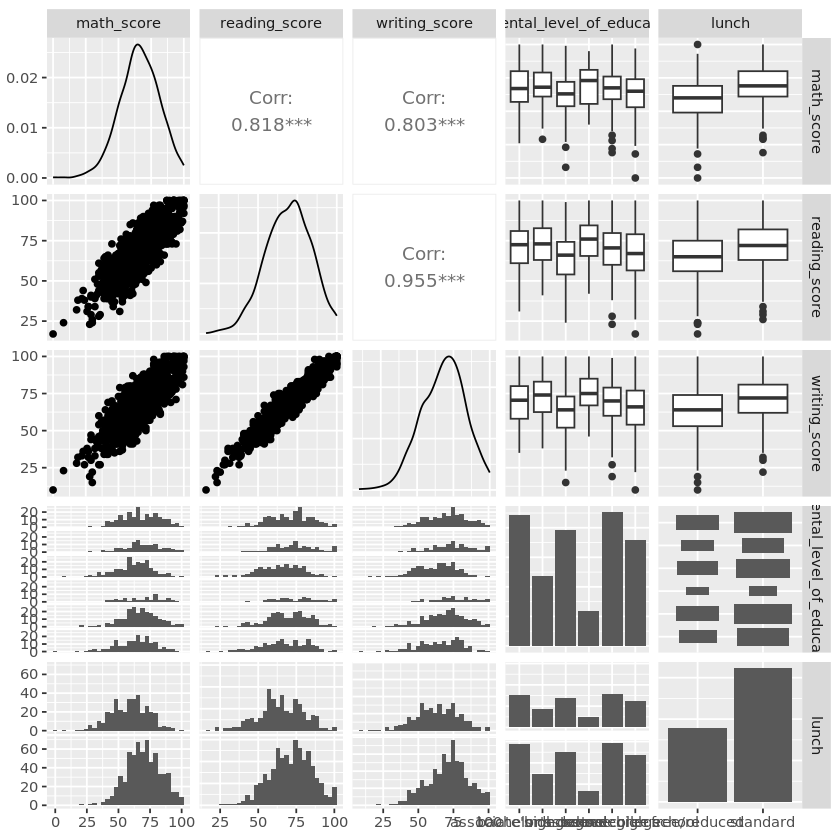

In [116]:
studentscor <- students[c('math_score', 'reading_score', 'writing_score','parental_level_of_education','lunch')]
ggpairs(studentscor)

### Results
All test scores (math, reading, and writing) have normal distributions, with a slight skew towards higher scores. Most students have parents with 'some college' or 'high school' education, and the majority of students also have standard lunch statuses. The math vs. reading correlation is strongly positive at 0.818, math vs. writing correlation is also strongly positive at 0.803, and the reading vs. writing correlation is very strongly positive at 0.955. The reading and writing scores are very closely related, which is expected since they measure similar academic skills. Math scores are also positively correlated with both reading and writing, though to a slightly lesser extent. 

The scatter plots show tight clustering along upward sloping trends confirming the strong positive correlations. There are no obvious outliers or non-linear relationships between the variables. The higher levels of parental education are associated with higher test scores across all subjects. Students with parents who have master's or bachelor's degrees tend to have higher median scores, while those with 'some high school' or 'high school' have lower scores. Students on standard lunch consistently outperform those on free/reduced lunch in test scores, confirming socioeconomic disparities in academic performance.

In [87]:
# correlation matrix
testcor <- cor(studentscor[, c('math_score', 'reading_score', 'writing_score')], use = 'complete.obs')

# Display correlation matrix with stargazer
stargazer(testcor, type = 'text', title = 'correlation matrix of test scores')


correlation matrix of test scores
              math_score reading_score writing_score
----------------------------------------------------
math_score        1          0.818         0.803    
reading_score   0.818          1           0.955    
writing_score   0.803        0.955           1      
----------------------------------------------------


In [106]:
students <- students %>%
    mutate(
    testprepbin = if_else(test_preparation_course == "none", 0, 1),
    lunchbin = if_else(lunch == "free/reduced", 0, 1)
  )

In [93]:
unique(students$testprepbin)

[1] 0 1

In [107]:
unique(students$lunchbin)

[1] 1 0

In [108]:
unique(students$parental_level_of_education)

[1] "bachelor's degree"  "some college"       "master's degree"   
[4] "associate's degree" "high school"        "some high school"

In [1]:
students <- students %>%
  mutate(
    edunum = case_when(
      parental_level_of_education == "some high school" ~ 1,
      parental_level_of_education == "high school" ~ 2,
      parental_level_of_education == "some college" ~ 3,
      parental_level_of_education == "associate\'s degree" ~ 4,
      parental_level_of_education == "bachelor\'s degree" ~ 5,
      parental_level_of_education == "master\'s degree" ~ 6,
      TRUE ~ NA_real_ 
    )
  )

ERROR: Error in students %>% mutate(edunum = case_when(parental_level_of_education == : could not find function "%>%"


In [110]:
unique(students$edunum)

[1] 5 3 6 4 2 1

In [111]:
prepedu <- cor(students[c('testprepbin', 'edunum')], use = 'complete.obs')
stargazer(prepedu, type = 'text', title = 'correlation matrix of test prep and parent education')


correlation matrix of test prep and parent education
            testprepbin edunum
------------------------------
testprepbin      1      -0.007
edunum        -0.007      1   
------------------------------


In [113]:
preplunch <- cor(students[c('testprepbin', 'lunchbin')], use = 'complete.obs')
stargazer(preplunch, type = 'text', title = 'correlation matrix of test prep and lunch status')


correlation matrix of test prep and lunch status
            testprepbin lunchbin
--------------------------------
testprepbin      1       -0.017 
lunchbin      -0.017       1    
--------------------------------


In [114]:
edulunch <- cor(students[c('edunum', 'lunchbin')], use = 'complete.obs')
stargazer(edulunch, type = 'text', title = 'correlation matrix of parent education and lunch status')


correlation matrix of parent education and lunch status
         edunum lunchbin
------------------------
edunum     1     -0.023 
lunchbin -0.023    1    
------------------------


In [96]:
mathprep <- cor(students[c('testprepbin', 'math_score')], use = 'complete.obs')
stargazer(mathprep, type = 'text', title = 'correlation matrix of test prep and math exam scores')


correlation matrix of test prep and math exam scores
            testprepbin math_score
----------------------------------
testprepbin      1        0.178   
math_score     0.178        1     
----------------------------------


In [98]:
writingprep <- cor(students[c('testprepbin', 'writing_score')], use = 'complete.obs')
stargazer(writingprep, type = 'text', title = 'correlation matrix of test prep and writing exam scores')


correlation matrix of test prep and writing exam scores
              testprepbin writing_score
---------------------------------------
testprepbin        1          0.313    
writing_score    0.313          1      
---------------------------------------


In [99]:
readingprep <- cor(students[c('testprepbin', 'reading_score')], use = 'complete.obs')
stargazer(readingprep, type = 'text', title = 'correlation matrix of test prep and reading exam scores')


correlation matrix of test prep and reading exam scores
              testprepbin reading_score
---------------------------------------
testprepbin        1          0.242    
reading_score    0.242          1      
---------------------------------------


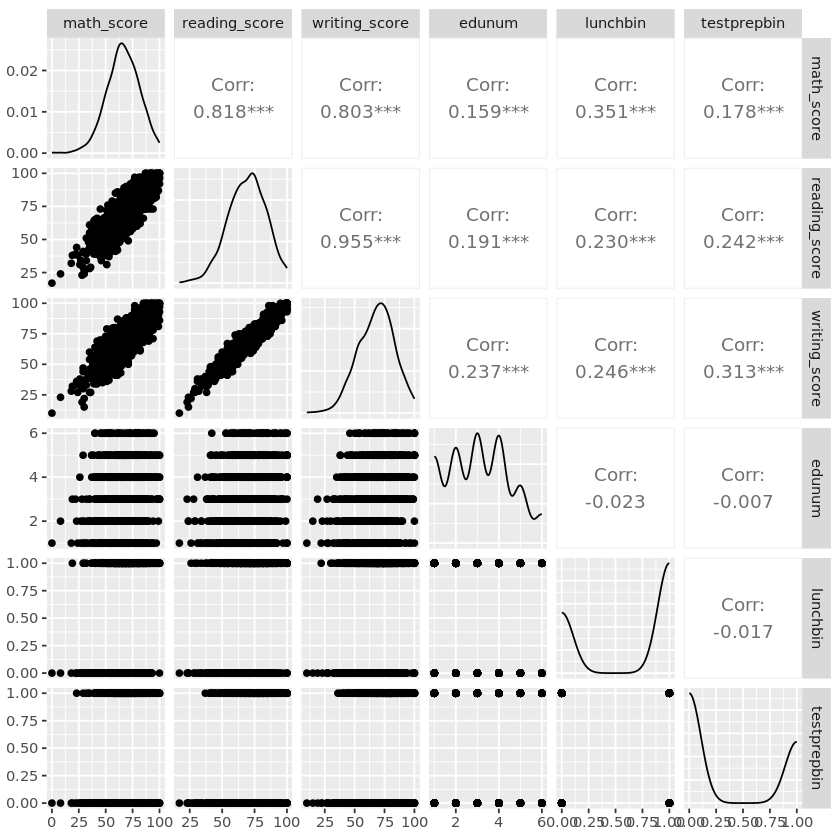

In [121]:
studentscorr <- students[c('math_score', 'reading_score', 'writing_score','edunum','lunchbin','testprepbin')]
ggpairs(studentscorr)

### Implications
The findings suggest that school lunch programs and support for families of lower socioeconomic status may help address academic disparities. 